### Figures and Tables for CERI-2016 PAPER  (RecsysChallenge 2015 dataset)
* Reading and processing the file takes a bit of time
* The rest should run smoothly

In [1]:
import read_data
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
%matplotlib inline 

In [2]:
# default parameters for saving the figures that look nice in a paper
plt.rcParams.update({'font.size': 19})
plt.rcParams['figure.figsize'] = (9, 6.4)
reload_figures = False
data_folder = '../data/'

In [3]:
# load all the files generated by read_dataset.py
start_time = time.time()
clicks = read_data.load_clicks(data_folder)
buys = read_data.load_buys(data_folder)
clicks_categories = read_data.load_categories(data_folder)
print("reading the dataset may take ~ %s seconds ---" % (time.time() - start_time))

reading the dataset may take ~ 1008.9959218502045 seconds ---


In [4]:
# merge clicks and purchases in a single dataframe
clicks_ = clicks[['session_id', 'timestamp', 'item_id', 'fulldate']]
buys_ = buys[['session_id', 'timestamp', 'item_id', 'purchase', 'fulldate']]
all_data = clicks_.append(buys_)

interactions_item = all_data['item_id'].value_counts()
data_session = all_data.groupby('session_id').count().reset_index()
data_session_purchase = data_session[data_session.purchase >= 1]

# check session length in time (seconds)
alldata_time = all_data.drop(['item_id', 'purchase', 'timestamp'], 1)
alldata_time = alldata_time.sort_values(by=['session_id', 'fulldate'], ascending=True)

In [5]:
# first and last interaction of each session (to calculate the difference)
session_first = alldata_time.drop_duplicates(subset='session_id', keep='first').reset_index()
session_last = alldata_time.drop_duplicates(subset='session_id', keep='last').reset_index()
session_diff = pd.DataFrame()
session_dif = pd.merge(session_first, session_last, how='inner', on='session_id')
time_delta_session = session_dif['fulldate_y'] - session_dif['fulldate_x']

In [6]:
# basic statistics (for intro)
print('number of items', len(clicks.item_id.unique()))
print('number of sessions', len(clicks.session_id.unique()))
print('number of clicks', len(clicks))
print('number of purchase events', len(buys))

# table 1 
print('Interactions per item \t', min(interactions_item),'\t' , interactions_item.median(),'\t' , max(interactions_item),'\t' , np.percentile(interactions_item,90))
print('session_length (events) \t', min(data_session['item_id']),'\t' , data_session['item_id'].median(),'\t' , max(data_session['item_id']),'\t' , np.percentile(data_session['item_id'],90))
print('session_length (time) \t', min(time_delta_session), ' \t ',  time_delta_session.median(), ' \t ' , np.percentile(time_delta_session, 90),  '\t ', max(time_delta_session))
print('Purchases per session \t', min(data_session_purchase['purchase']),'\t' , data_session_purchase['purchase'].median(),'\t' ,  np.percentile(data_session_purchase['purchase'],90),'\t' , max(data_session_purchase['purchase']))

number of items 52739
number of sessions 9249729
number of clicks 33003943
number of purchase events 1150752
Interactions per item 	 1 	 23.0 	 162622 	 978.2
session_length (events) 	 1 	 2.0 	 262 	 7.0
session_length (time) 	 0 days 00:00:00  	  0 days 00:02:14.387000  	  1078886999999 nanoseconds 	  2 days 20:18:57.996000
Purchases per session 	 1 	 2.0 	 4.0 	 144


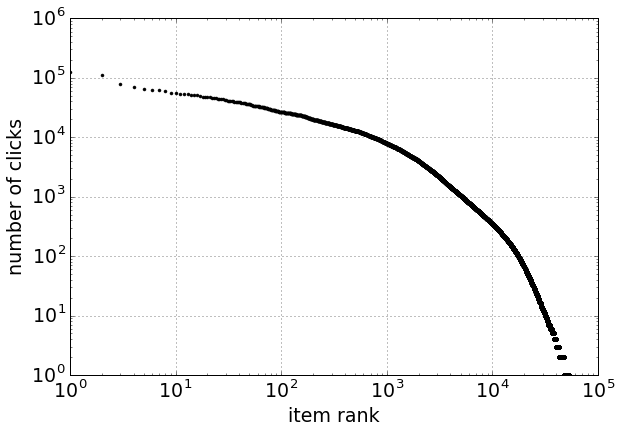

In [7]:
# figure 1 : item popularity in clicks and purchases
click_pop = pd.DataFrame(clicks['item_id'].value_counts()).sort_values(by='item_id', ascending=False).reset_index()
plt.plot(click_pop['item_id'], 'k.')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('number of clicks')
plt.xlabel('item rank')
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/pop.png')

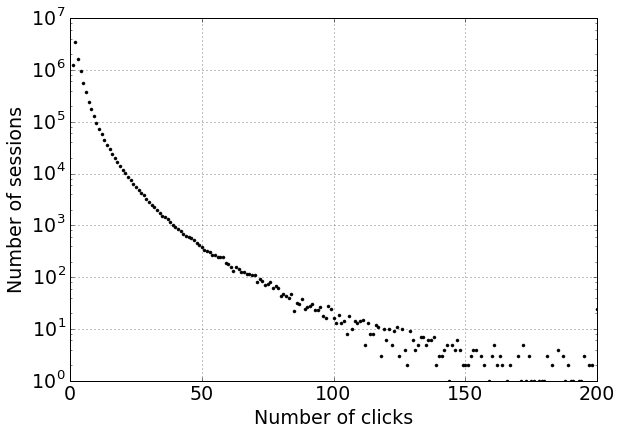

In [8]:
# figure 2: SESSION LENGTH (IN NUMBER OF CLICKS)
data_session = all_data.groupby('session_id').count().reset_index()
session_length_dist = data_session['item_id'].value_counts().sort_index()

plt.plot(session_length_dist.index[0:188], session_length_dist[0:188], 'k.')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Number of clicks')
plt.ylabel('Number of sessions')
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/session_clicks.png')

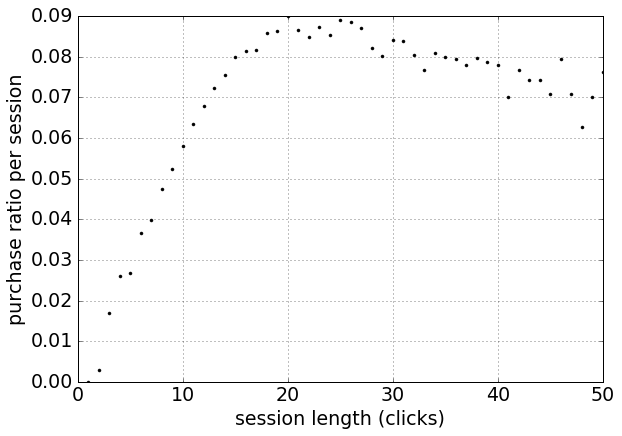

In [9]:
# Figure 3: Click distribution sorted by total number of sessions with purchases.
aux = data_session[['purchase', 'timestamp', 'item_id']]
purchases_per_session_length = aux.groupby('timestamp').sum().reset_index()
purchases_per_session_length.corr(method='pearson')
fig = plt.subplots()
plt.plot(purchases_per_session_length.timestamp[0:50], purchases_per_session_length.purchase[0:50]/purchases_per_session_length.item_id[0:50], 'k.')
plt.grid(True)
plt.tight_layout()
plt.xlabel('session length (clicks)')
plt.ylabel('purchase ratio per session')
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/click_distro.png')

In [10]:
# Table 2 : Monthly clicks and purchases distribution (per month)
monthly_activity = pd.DataFrame(clicks['month'].value_counts()).sort_index().transpose()
monthly_activity = monthly_activity.append(pd.DataFrame(buys['month'].value_counts()).sort_index().transpose())
ratio  = pd.DataFrame(buys['month'].value_counts()).sort_index().transpose() / pd.DataFrame(clicks['month'].value_counts()).sort_index().transpose()

print(monthly_activity)
print(ratio)

             4        5        6        7        8        9
month  5973370  5544429  5127025  4434056  6646541  5278522
month   178718   181213   171271   158516   257910   203124
              4         5         6        7         8         9
month  0.029919  0.032684  0.033406  0.03575  0.038804  0.038481


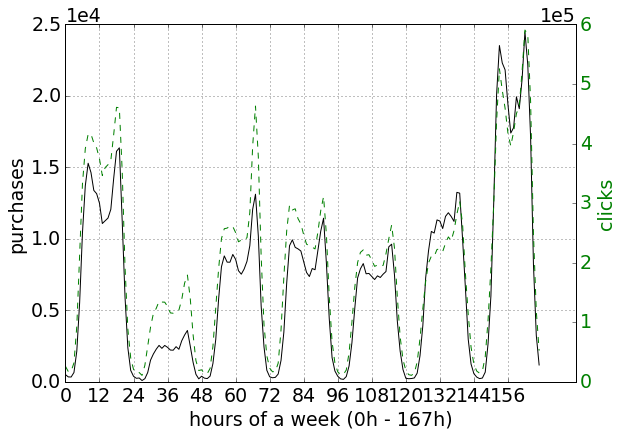

In [11]:
# Figure 4: WEEKLY CLICKS AND PURCHASES
buys_hourweekday = pd.DataFrame(buys['hourweekday'].value_counts()).sort_index()
clicks_hourweekday = pd.DataFrame(clicks['hourweekday'].value_counts()).sort_index()

fig, ax1 = plt.subplots()
ax1.plot(buys_hourweekday.index, buys_hourweekday.hourweekday, 'k-')
ax1.grid(True)
ax1.set_xlabel('hours of a week (0h - 167h)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('purchases', color='k')
for tl in ax1.get_yticklabels(): tl.set_color('k')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

ax2 = ax1.twinx()
ax2.plot(clicks_hourweekday.index, clicks_hourweekday.hourweekday, 'g--')
ax2.set_ylabel('clicks', color='g')
for tl in ax2.get_yticklabels(): tl.set_color('g')

plt.xticks(np.arange(0, 168, 12.0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/week.png')

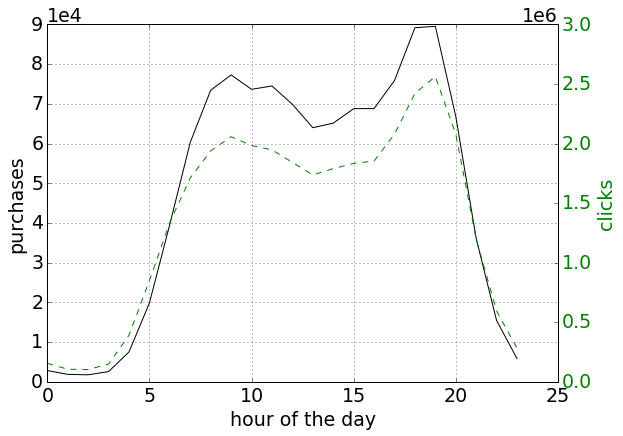

In [12]:
# Figure 5: DAILY CLICKS AND PURCHASES
buys_hour = pd.DataFrame(buys['hour'].value_counts()).sort_index()
clicks_hour = pd.DataFrame(clicks['hour'].value_counts()).sort_index()

fig, ax1 = plt.subplots()
ax1.plot(buys_hour.index, buys_hour.hour, 'k-')
ax1.grid(True)
ax1.set_xlabel('hour of the day')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('purchases', color='k')
for tl in ax1.get_yticklabels(): tl.set_color('k')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(clicks_hour.index, clicks_hour.hour, 'g--')
ax2.set_ylabel('clicks', color='g')
for tl in ax2.get_yticklabels(): tl.set_color('g')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/fullday.png')

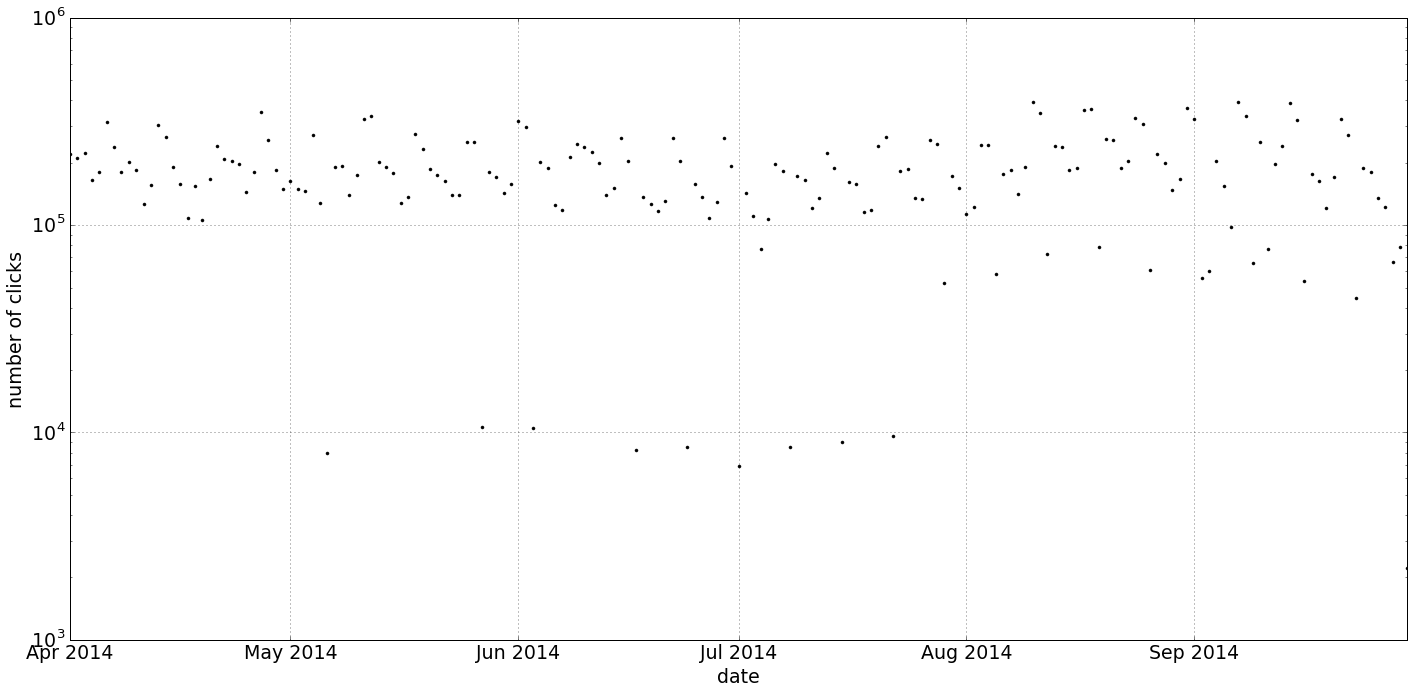

In [13]:
# Figure 6 : Activity per day overall
# we can detect annomalies in the shop by doing this
clicks_days = pd.DataFrame(clicks['date'].value_counts()).sort_index()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(clicks_days.index, clicks_days.date, 'k.')
plt.yscale('log')
plt.grid(True)
plt.xlabel('date')
plt.ylabel('number of clicks')
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/history.png')

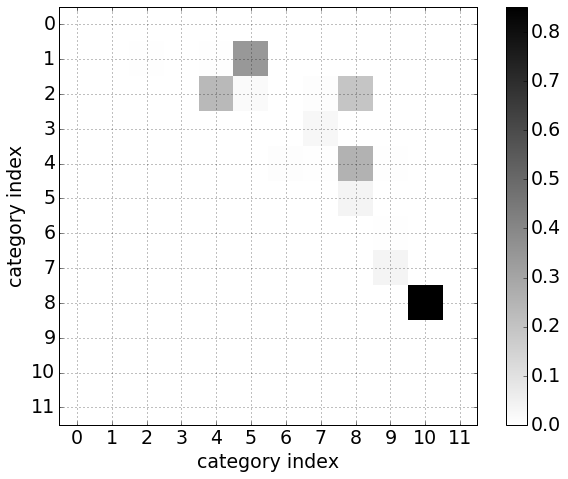

In [14]:
# Figure 7: Category plot
clicks_categories = clicks_categories[(clicks_categories.category > 0) & (clicks_categories.category < 13)]
category_size = pd.DataFrame(clicks_categories['category'].value_counts()).sort_index()

# normalized category similarity
cat_sim = np.zeros((12, 12))
for i in range(1,12):
    for j in range(i+1, 12):
        set_a = set(clicks_categories.item_id[clicks_categories.category == i])
        set_b = set(clicks_categories.item_id[clicks_categories.category == j])
        cat_sim[i][j] = float(len(set_a.intersection(set_b)) / min(len(set_a), len(set_b)))


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
plt.imshow(cat_sim, interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.grid(True)
plt.xticks(np.arange(0, 12))
plt.yticks(np.arange(0, 12))
plt.xlabel('category index')
plt.ylabel('category index')
plt.tight_layout()
if reload_figures: plt.savefig('latex/figures/categories.png')